## 读取模型并计算SHAP values

In [2]:
import pickle
from shap import Explanation
import pandas as pd
import shap
from shap import LinearExplainer, KernelExplainer, Explanation
shap.initjs()
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

with open('metrics/best_model_item.pkl', 'rb') as f:
    best_model_item = pickle.load(f)
clf_stacking = best_model_item['clf']
best_model_index = best_model_item['index']
print("The index (random state) used for the best model is: ", best_model_index)

The index (random state) used for the best model is:  33


In [3]:

# Load the data from Excel
xls = pd.ExcelFile('split_csv/Stacking_indices33.xlsx')
df_train = pd.read_excel(xls, 'Hold Train')
df_test = pd.read_excel(xls, 'Hold Test')

# Extract features and labels
X_train = df_train.drop(columns=['Y', 'Unnamed: 0'])  
y_train = df_train['Y']

X_test = df_test.drop(columns=['Y', 'Unnamed: 0']) 
y_test = df_test['Y']


with open('metrics/best_model_item.pkl', 'rb') as f:
    best_model_item = pickle.load(f)
clf_stacking = best_model_item['clf']


clf_stacking.fit(X_train, y_train)


np.random.seed(42) #使用的是 Monte Carlo 采样来估计这些值，存在一定随机性

explainer = shap.KernelExplainer(clf_stacking.predict, X_test) 
sv = explainer.shap_values(X_test)

data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'clf_stacking': clf_stacking,
    'shap_values': sv,
    'expected_value': explainer.expected_value,
    'feature_names': X_test.columns
}

with open('./data/shap_all_info.pkl', 'wb') as f: #存储为pkl，防止每次都得计算
    pickle.dump(data_dict, f)

  0%|          | 0/23 [00:00<?, ?it/s]

In [4]:
import pickle
from shap import Explanation
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import shap
from shap import LinearExplainer, KernelExplainer, Explanation
shap.initjs()
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

with open('./data/shap_all_info.pkl', 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X_train']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_test = data_dict['y_test']
clf_stacking = data_dict['clf_stacking']
shap_values = data_dict['shap_values']
feature_names = data_dict['feature_names']
expected_value = data_dict['expected_value']

In [5]:
import matplotlib.pyplot as plt

# Set the global font to be bold, size 12
plt.rcParams['font.weight'] = 'bold'

In [6]:
print(X_test.columns) 

Index(['US', 'DSBT_Span', 'Stroop_neutral_rt', 'Stroop_interference_effect_rt',
       'RM-1,750_acc', 'Switch_cost', 'EFF', 'Stroop_incongruent_rt',
       'Nogo_acc', 'IF', 'Go_rt', 'RM-750_acc', 'Mixing_cost', 'CBT_acc',
       'IUF', 'CBT_Span', 'Stroop_congruent_rt', 'ISF', 'Go_acc'],
      dtype='object')


### 输出SHAP values


In [7]:
# Predict the labels of the test set
y_pred = clf_stacking.predict(X_test)

# Create a dataframe for the comparison
prediction_comparison = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}) # Notice the change to 'y_test'

# Only keep the correctly predicted rows
correct_predictions = prediction_comparison[prediction_comparison['y_true'] == prediction_comparison['y_pred']]

# Add the correctly predicted flag to the shap_values dataframe
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns) # Notice the change to 'shap_values'
shap_values_df['Correct Prediction'] = shap_values_df.index.isin(correct_predictions.index)

# Add the predicted class to the shap_values dataframe
shap_values_df['Predicted Class'] = y_pred

# Create a new DataFrame to store the original feature values
original_values_df = X_test.copy()
original_values_df['Correct Prediction'] = original_values_df.index.isin(correct_predictions.index)
original_values_df['Predicted Class'] = y_pred

# Use pandas' ExcelWriter function to write the two DataFrames into different worksheets in the same Excel file
with pd.ExcelWriter('./table/output_values-测试集所有样本.xlsx') as writer:
    shap_values_df.to_excel(writer, sheet_name='SHAP Values')
    original_values_df.to_excel(writer, sheet_name='Original Feature Values')

In [8]:
xls = pd.ExcelFile('split_csv/Stacking_indices33.xlsx')

# 加载 'Test Data' 数据表
df_test_data = pd.read_excel(xls, 'Test Data')

# 添加到 'SHAP Values' 数据表
shap_values_df = pd.concat([shap_values_df, df_test_data], axis=1)



# 将更新后的数据表存储到一个新的 Excel 文件中
with pd.ExcelWriter('./table/output_values_filtered-所有样本.xlsx') as writer:
    shap_values_df.to_excel(writer, sheet_name='SHAP Values Filtered')
    original_values_df.to_excel(writer, sheet_name='Original Feature Values')

In [9]:
xls = pd.ExcelFile('split_csv/Stacking_indices33.xlsx')

# 加载 'Test Data' 数据表
df_test_data = pd.read_excel(xls, 'Test Data')

# 添加到 'SHAP Values' 数据表
shap_values_df = pd.concat([shap_values_df, df_test_data], axis=1)

# 删除 'Correct Prediction' 为 False 的行
shap_values_df = shap_values_df[shap_values_df['Correct Prediction'] != False]



# 将更新后的数据表存储到一个新的 Excel 文件中
with pd.ExcelWriter('./table/output_values_filtered-被正确预测的样本.xlsx') as writer:
    shap_values_df.to_excel(writer, sheet_name='SHAP Values Filtered')
    original_values_df.to_excel(writer, sheet_name='Original Feature Values')

In [10]:
xls = pd.ExcelFile('split_csv/Stacking_indices33.xlsx')

# 加载 'Test Data' 数据表
df_test_data = pd.read_excel(xls, 'Test Data')

# 添加到 'SHAP Values' 数据表
shap_values_df = pd.concat([shap_values_df, df_test_data], axis=1)

# 删除 'Correct Prediction' 为 False 的行
shap_values_df = shap_values_df[shap_values_df['Correct Prediction'] != False]

# 删除 'Predicted Class' 为 1 的行
shap_values_df = shap_values_df[shap_values_df['Predicted Class'] != 1]

# 将更新后的数据表存储到一个新的 Excel 文件中
with pd.ExcelWriter('./table/output_values_filtered-被正确预测为缓解的样本.xlsx') as writer:
    shap_values_df.to_excel(writer, sheet_name='SHAP Values Filtered')
    original_values_df.to_excel(writer, sheet_name='Original Feature Values')

### 决策路径（原始基于的SHAP values）

##### 一个样本

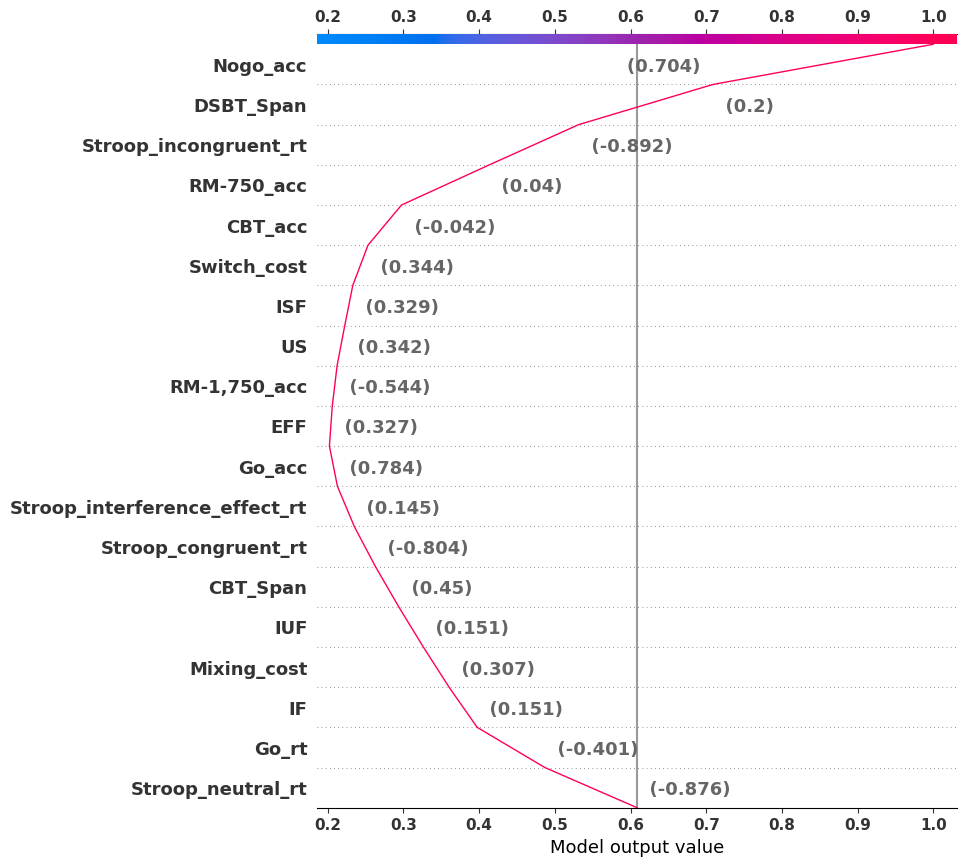

In [11]:

index_sample = 5

# Get the feature values and SHAP values of the sample
T_single = X_test.loc[[index_sample]]
sh_single = sv[[index_sample]]

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot for the single sample
shap.decision_plot(explainer.expected_value, sh_single, T_single, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_single_sample-5.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

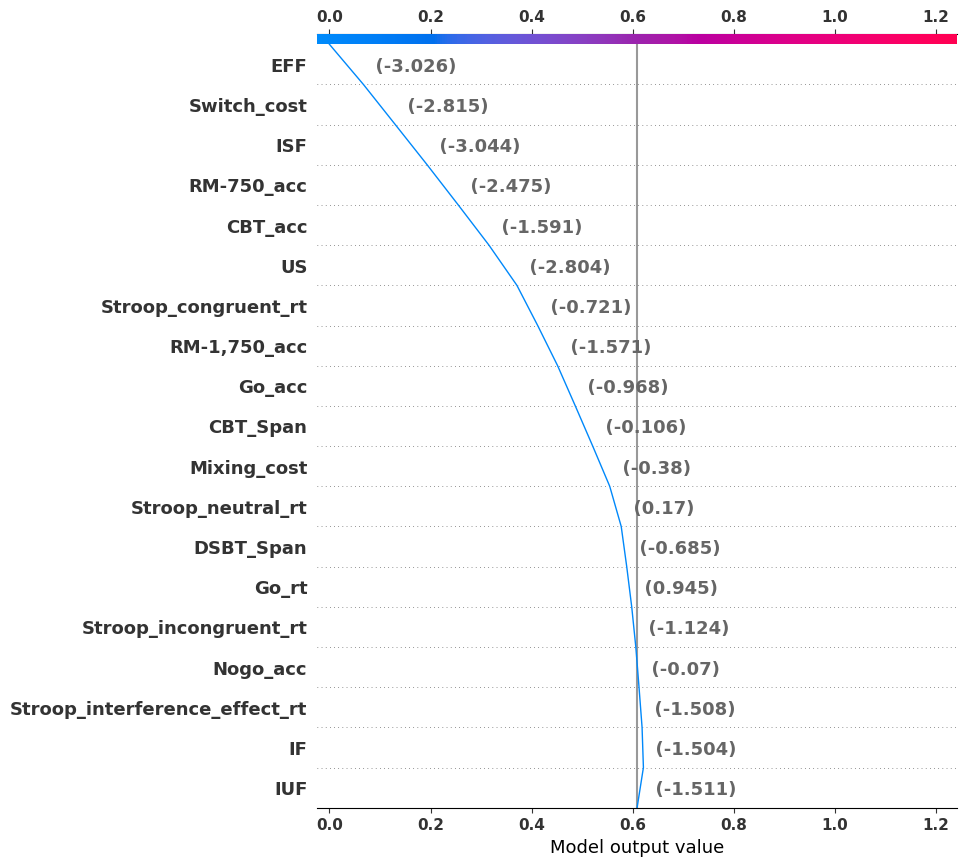

In [12]:

index_sample = 20

# Get the feature values and SHAP values of the sample
T_single = X_test.loc[[index_sample]]
sh_single = sv[[index_sample]]

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot for the single sample
shap.decision_plot(explainer.expected_value, sh_single, T_single, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_single_sample-20.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 所有被正确预测为患者和健康个体的的决策路径

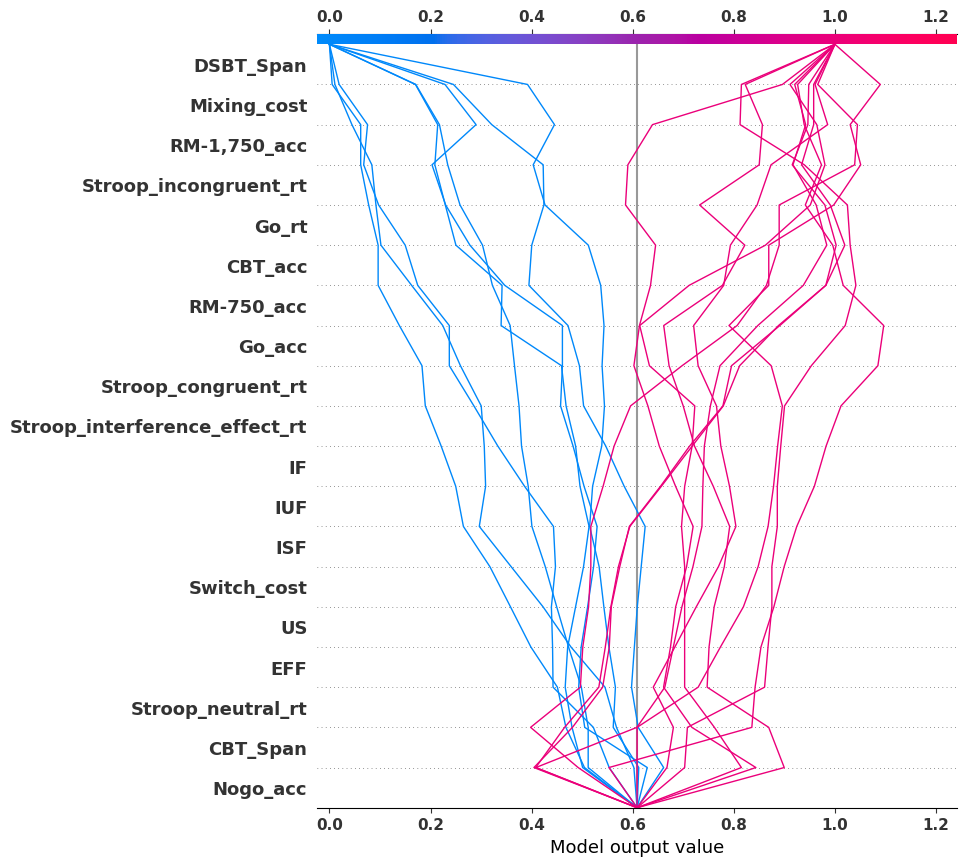

In [13]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the indices of the samples correctly predicted as 1
correct_1_indices = X_test[(y_test == 1) & (y_pred == 1)].index

# Combine the correct indices
correct_indices = correct_0_indices.append(correct_1_indices)

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_indices]
sh = sv[correct_indices]

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot
shap.decision_plot(explainer.expected_value, sh, T, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct所有被正确预测为患者和健康个体的的决策路径.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 所有被正确预测为患者的决策路径

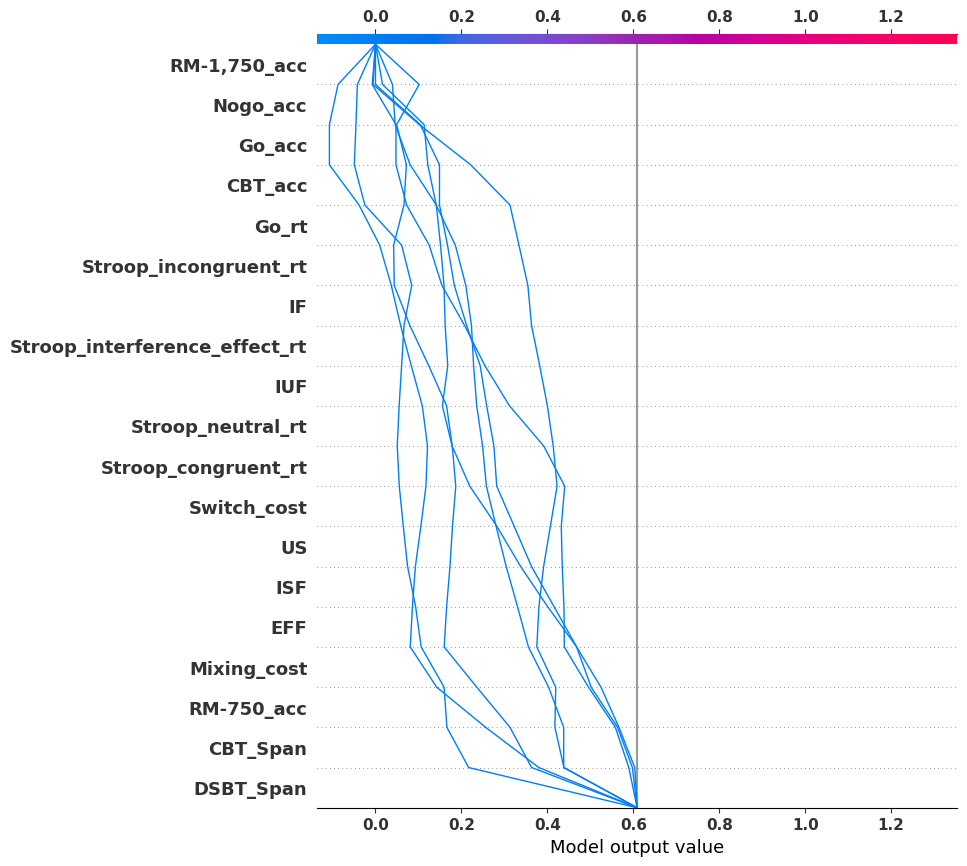

In [14]:

# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot
shap.decision_plot(explainer.expected_value, sh, T, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_所有被正确预测为患者.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 抑制能力较差，但是被正确预测为缓解的

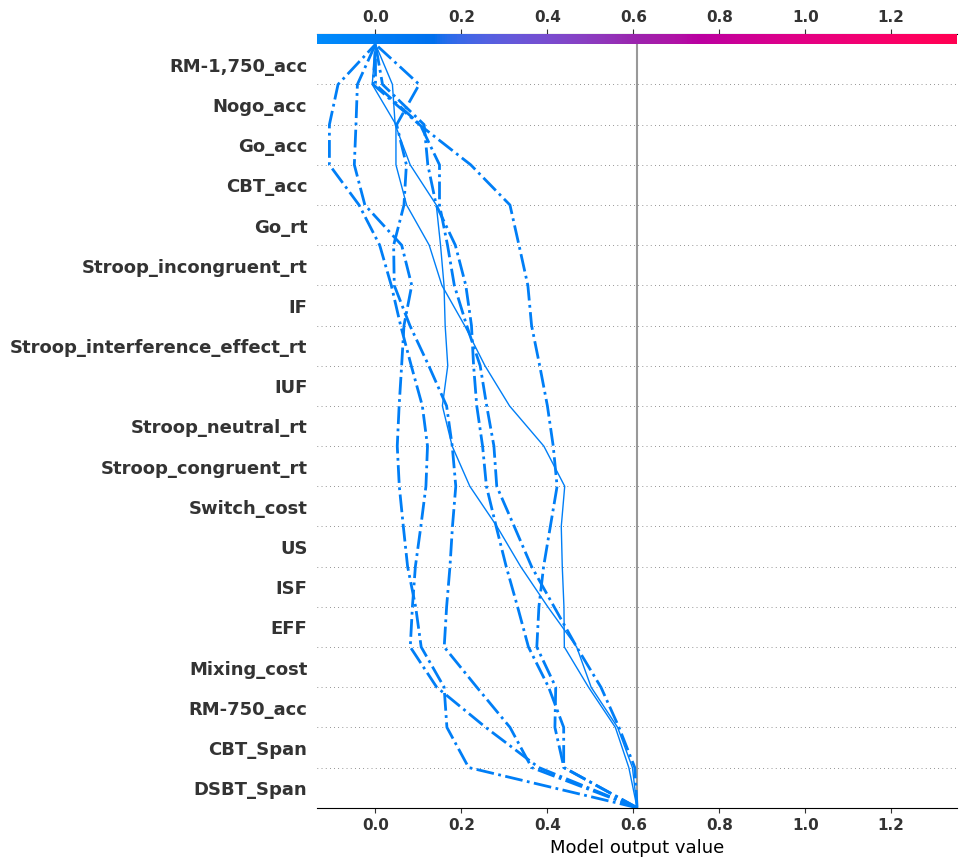

In [15]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative
is_highlight = (T['Stroop_incongruent_rt'] > 0) & (T['Stroop_congruent_rt'] > 0) & (T['Stroop_neutral_rt'] > 0)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_抑制能力不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 刷新能力较差，但是被正确预测为缓解的

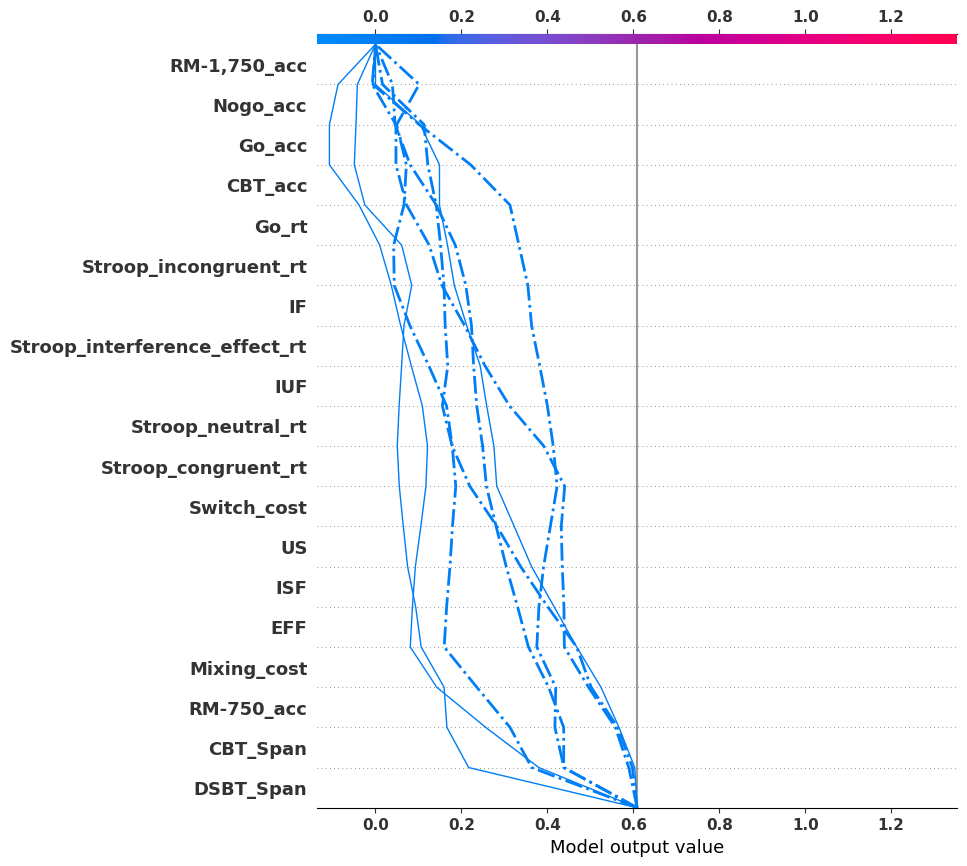

In [16]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative
is_highlight = (T['RM-1,750_acc'] < 0) & (T['RM-750_acc'] < 0)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_刷新能力不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 冲突抑制能力较差的，但是被正确预测为缓解的

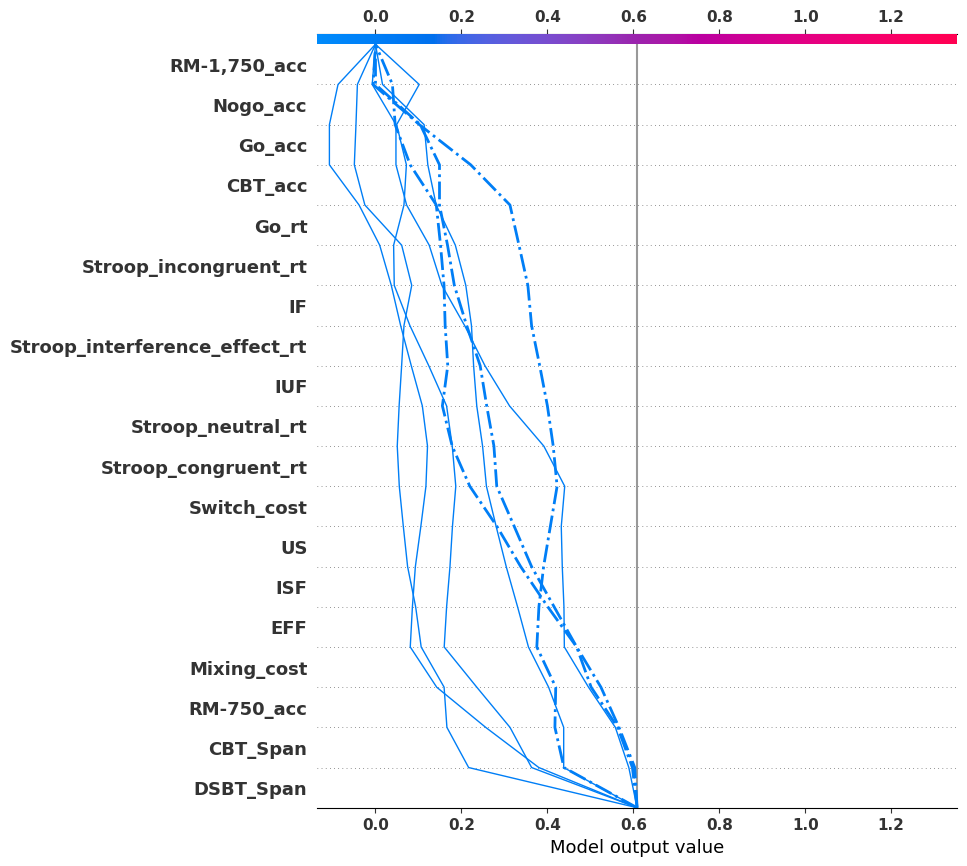

In [17]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test== 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative
is_highlight = (T['Nogo_acc'] < 0) & (T['Go_acc'] < 0) & (T['Go_rt'] > 0)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_冲突抑制能力不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 转换能力较差的，但是被正确预测为缓解的

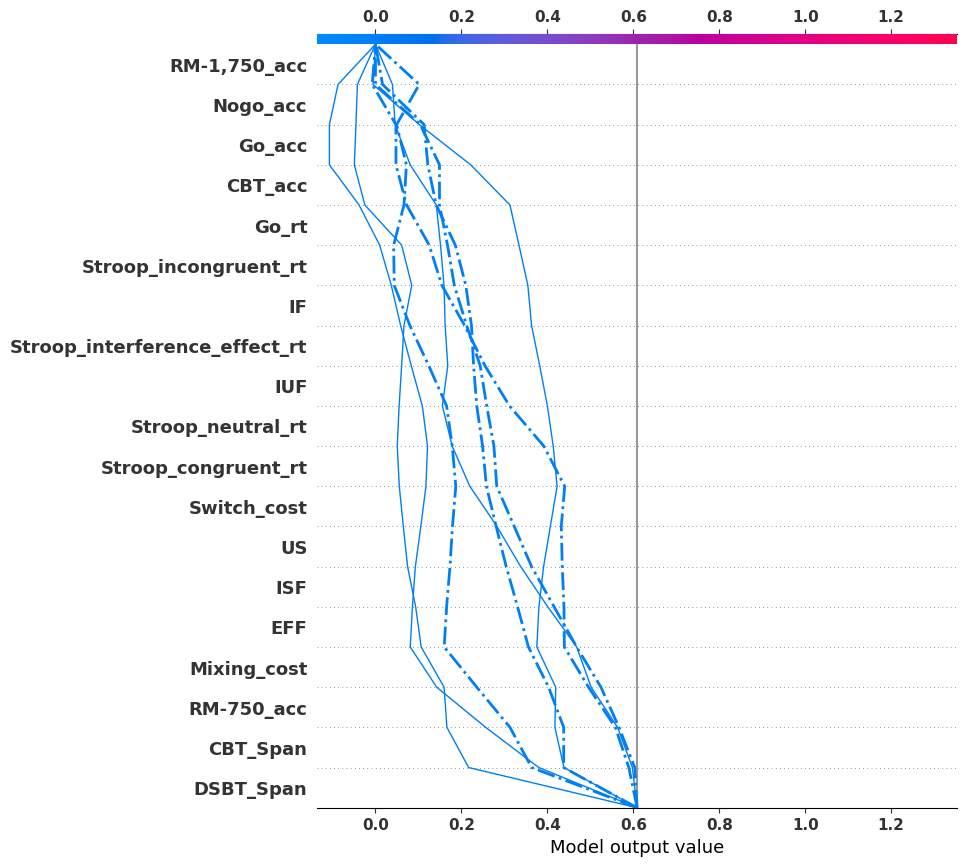

In [18]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative
is_highlight = (T['Switch_cost'] > 0) & (T['Mixing_cost'] < 0)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_转换能力不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

##### 工作记忆广度能力较差，但是被正确预测为缓解的

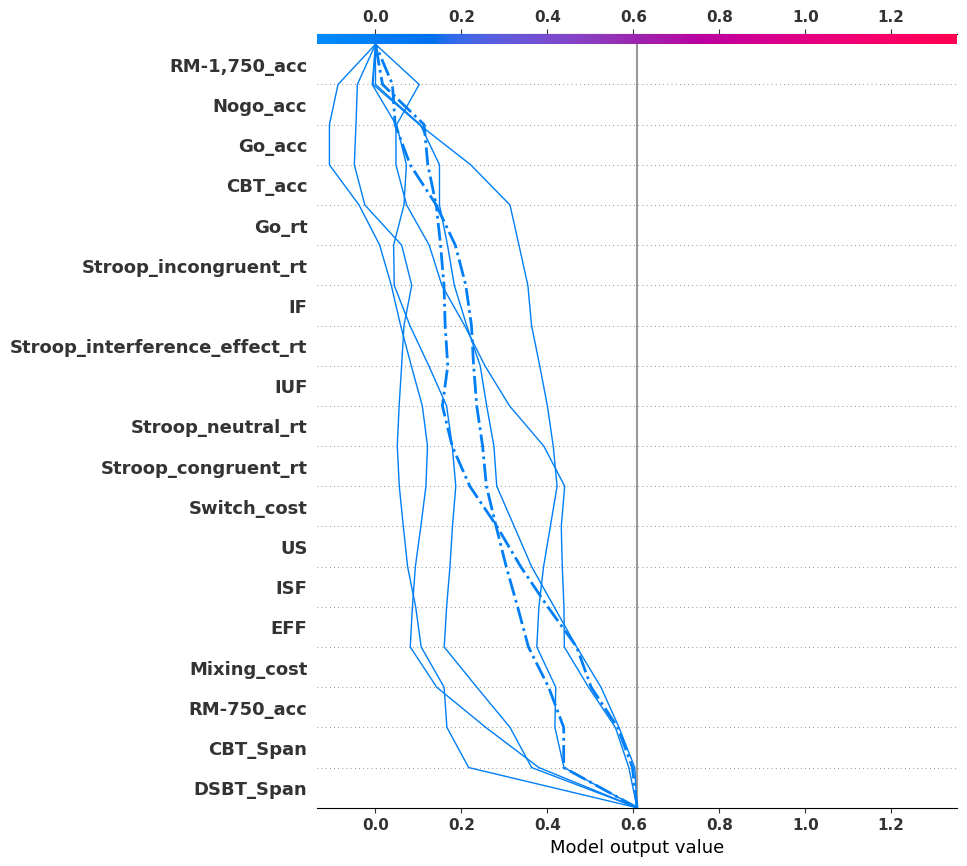

In [19]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative
is_highlight =((T['DSBT_Span'] < 0) &
    (T['CBT_Span'] < 0))

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_工作记忆广度能力不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

#### 执行功能都较差，但是被预测为缓解的

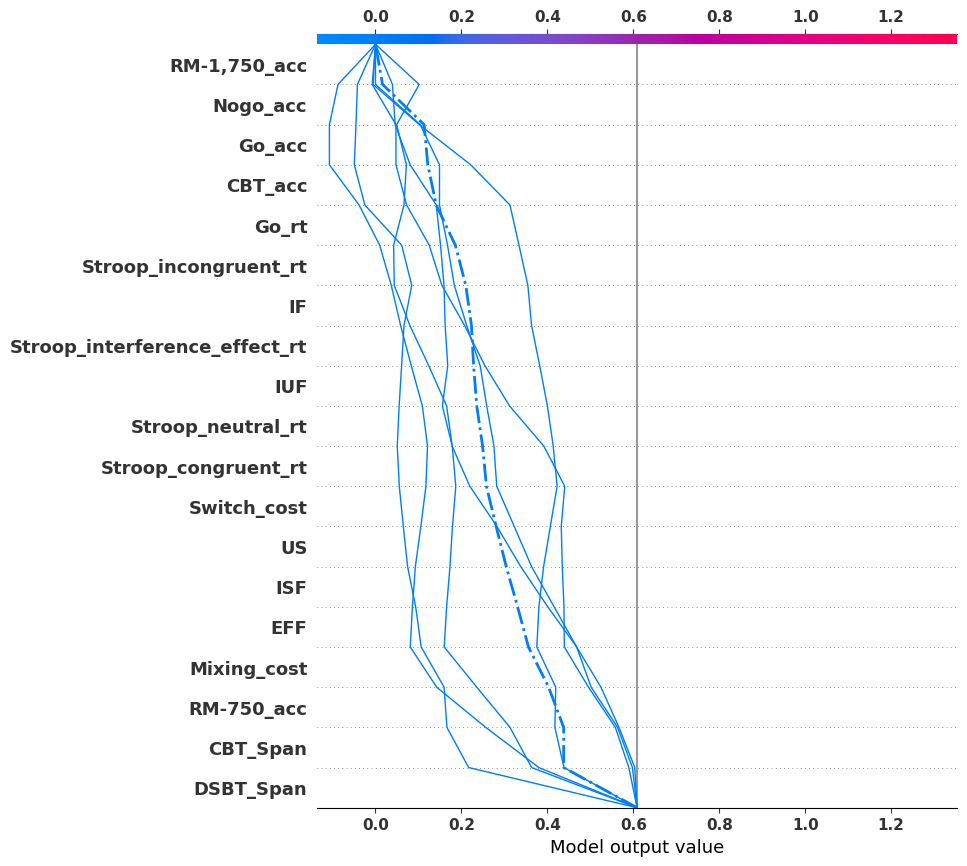

In [20]:
# Predict the class labels
y_pred = clf_stacking.predict(X_test)

# Get the indices of the samples correctly predicted as 0
correct_0_indices = X_test[(y_test == 0) & (y_pred == 0)].index

# Get the feature values and SHAP values of the samples
T = X_test.loc[correct_0_indices]
sh = sv[correct_0_indices]

# Create a boolean array indicating whether the 'Stroop_incongruent_rt' feature is negative

is_highlight = (
    (T['Stroop_incongruent_rt'] > 0) &
    (T['RM-1,750_acc'] < 0) &
    (T['Nogo_acc'] < 0) &
    (T['CBT_Span'] < 0) &
    (T['Switch_cost'] > 0) &
    (T['DSBT_Span'] < 0)
)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot, highlighting the specified samples
shap.decision_plot(explainer.expected_value, sh, T, highlight=is_highlight, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_correct_执行功能都不损伤.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

#### 所有被正确预测为缓解的平均预测路径

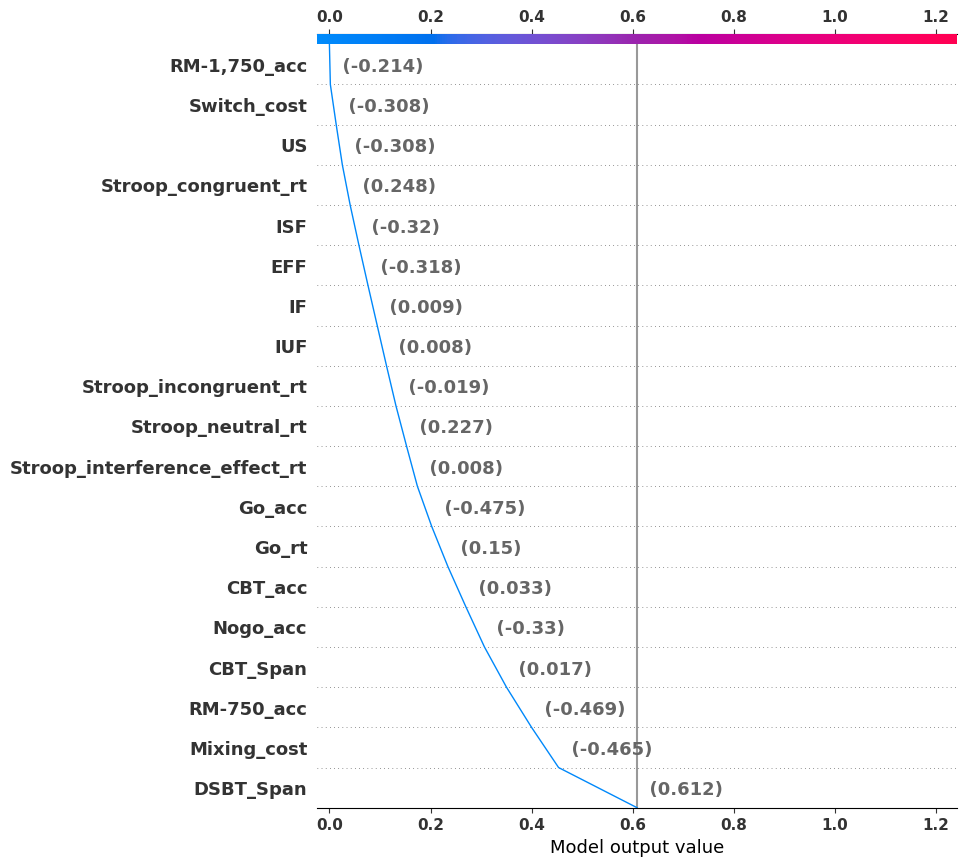

In [21]:
# Calculate the mean feature values and SHAP values
T_mean = T.mean(axis=0)
sh_mean = sh.mean(axis=0)

# Create a new figure with a specific size
plt.figure(figsize=(10, 8))

# Create the decision plot
shap.decision_plot(explainer.expected_value, sh_mean, T_mean, feature_order='hclust', show=False)

# Adjust the subplot layout
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)

# Save the figure
plt.savefig(f'image/decision_plot_mean_correct_0.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

#### Stacked force plot

In [22]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [23]:
shap.force_plot(explainer.expected_value, shap_values, X_test)
import shap

shap_values = explainer.shap_values(X_test)
shap.initjs()


force_plot = shap.force_plot(explainer.expected_value, shap_values, X_test)

shap.save_html('data/force_plot.html', force_plot)

  0%|          | 0/23 [00:00<?, ?it/s]

### Group level（整体加权）

#### Violin plot

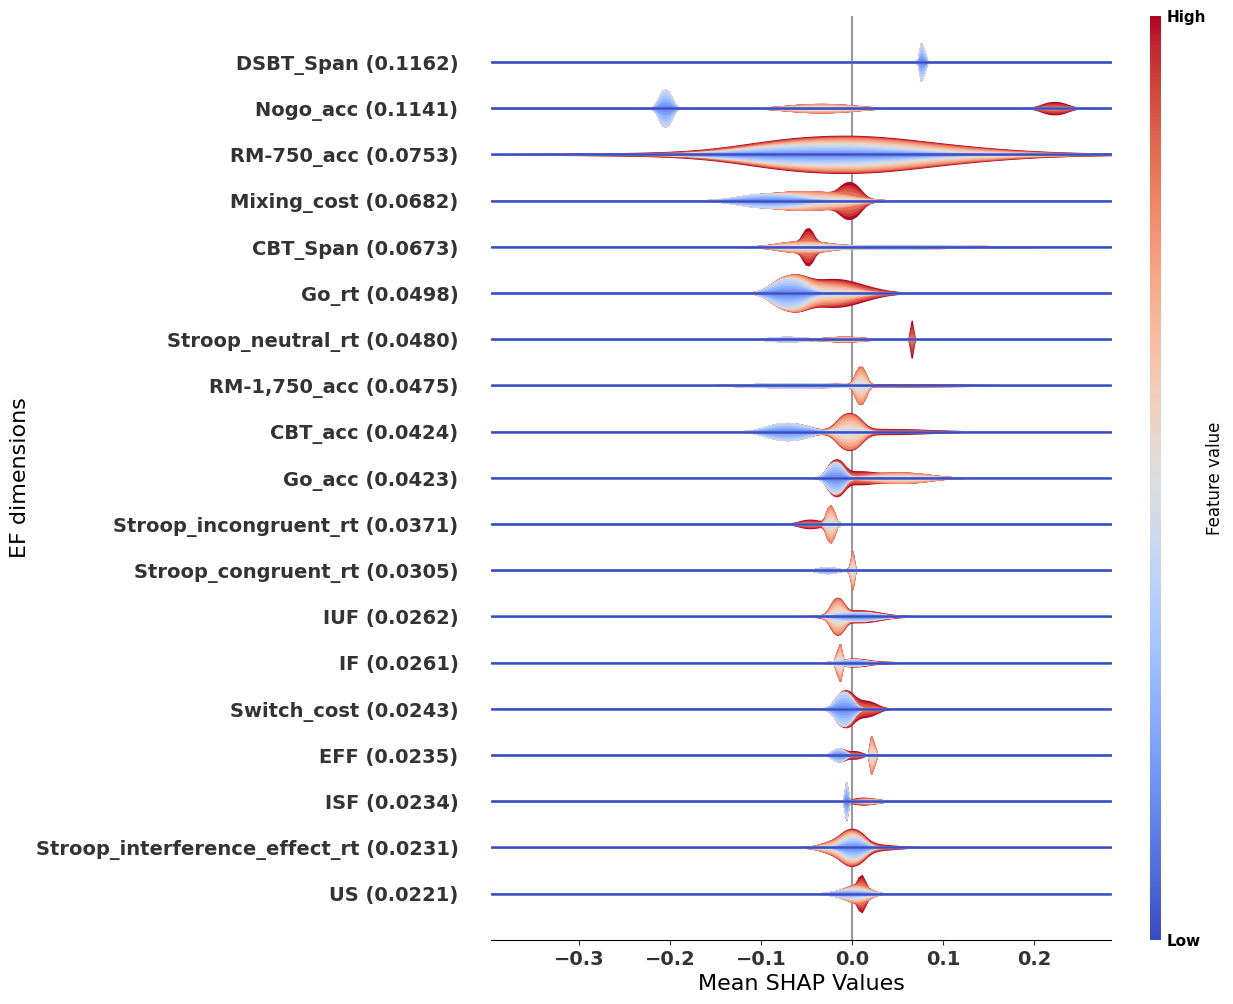

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shap

# 计算每个特征的 SHAP 值的绝对值的平均值
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# 设置全局的字体大小和粗细
mpl.rcParams['font.size'] = 14

# 生成 SHAP 值的小提琴图
shap.plots.violin(shap_values,X_test, plot_type="layered_violin",plot_size=(10,12),show=False,max_display=35)

ax = plt.gca()

# 获取 y 轴标签
yticklabels = ax.get_yticklabels()

feature_ordering = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]

# 设置 y 轴标签，并添加 SHAP 值
ax.set_yticklabels([f'{X_test.columns[feature_ordering[len(yticklabels)-i-1]]} ({mean_abs_shap_values[feature_ordering[len(yticklabels)-i-1]]:.4f})' for i in range(len(yticklabels))])

# 设置 x 轴和 y 轴的字体大小和粗细
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 设置 x 轴和 y 轴的标题，并指定字体大小
ax.set_xlabel('Mean SHAP Values', fontsize=16)
ax.set_ylabel('EF dimensions', fontsize=16)

# 保存图像
plt.savefig('image/summary_plot-小提琴图-蓝橙配色.jpg', dpi=600, bbox_inches='tight')

# 显示图像
plt.show()

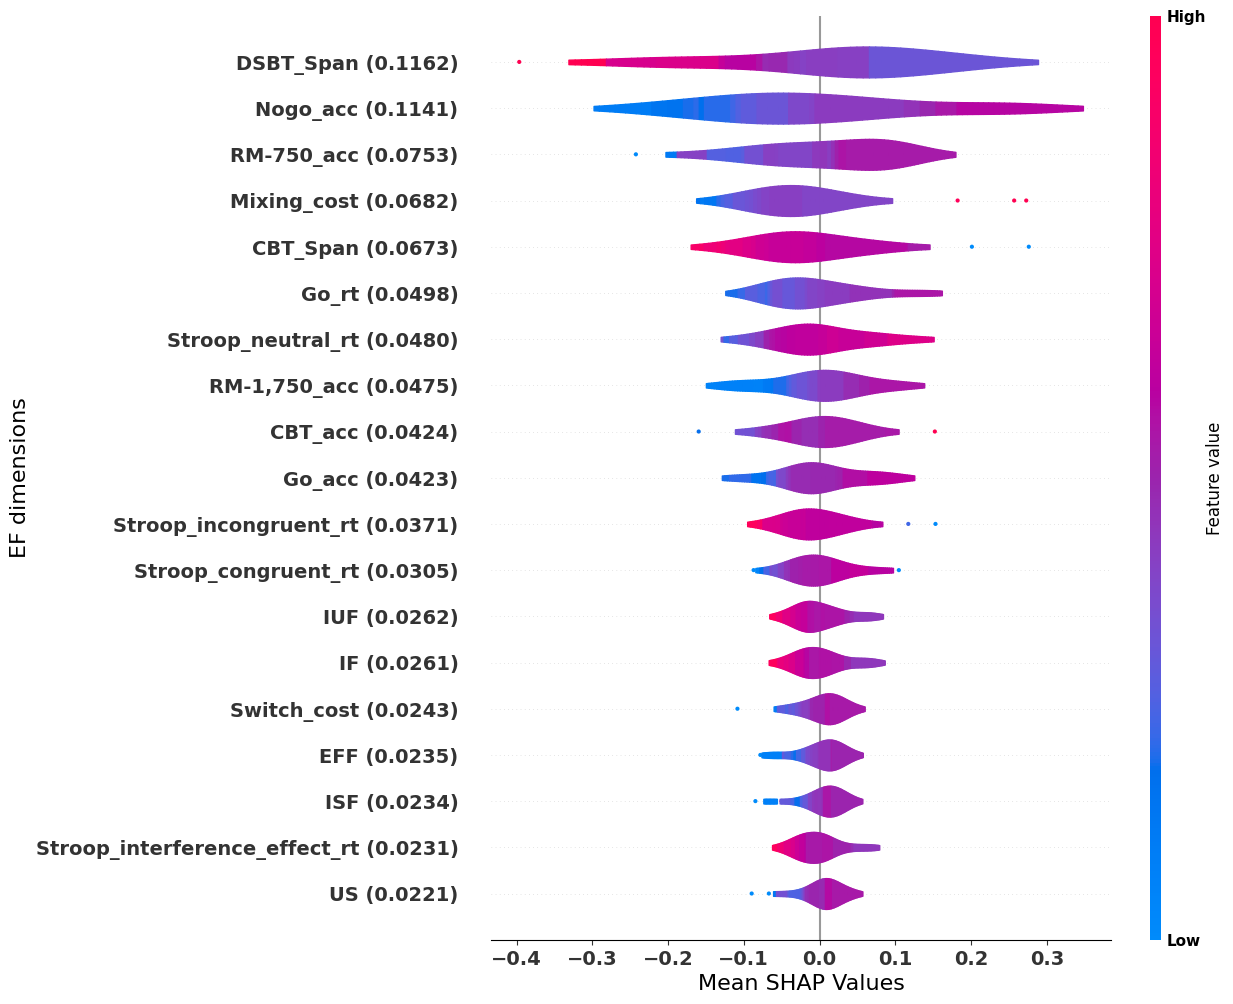

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shap

# 计算每个特征的 SHAP 值的绝对值的平均值
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# 设置全局的字体大小和粗细
mpl.rcParams['font.size'] = 14

# 生成 SHAP 值的小提琴图
shap.plots.violin(shap_values,X_test,plot_size=(10,12),show=False,max_display=35)

ax = plt.gca()

# 获取 y 轴标签
yticklabels = ax.get_yticklabels()

feature_ordering = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]

# 设置 y 轴标签，并添加 SHAP 值
ax.set_yticklabels([f'{X_test.columns[feature_ordering[len(yticklabels)-i-1]]} ({mean_abs_shap_values[feature_ordering[len(yticklabels)-i-1]]:.4f})' for i in range(len(yticklabels))])

# 设置 x 轴和 y 轴的字体大小和粗细
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 设置 x 轴和 y 轴的标题，并指定字体大小
ax.set_xlabel('Mean SHAP Values', fontsize=16)
ax.set_ylabel('EF dimensions', fontsize=16)

# 保存图像
plt.savefig('image/summary_plot-小提琴图-原始配色.jpg', dpi=600, bbox_inches='tight')

# 显示图像
plt.show()

#### beewarm plot

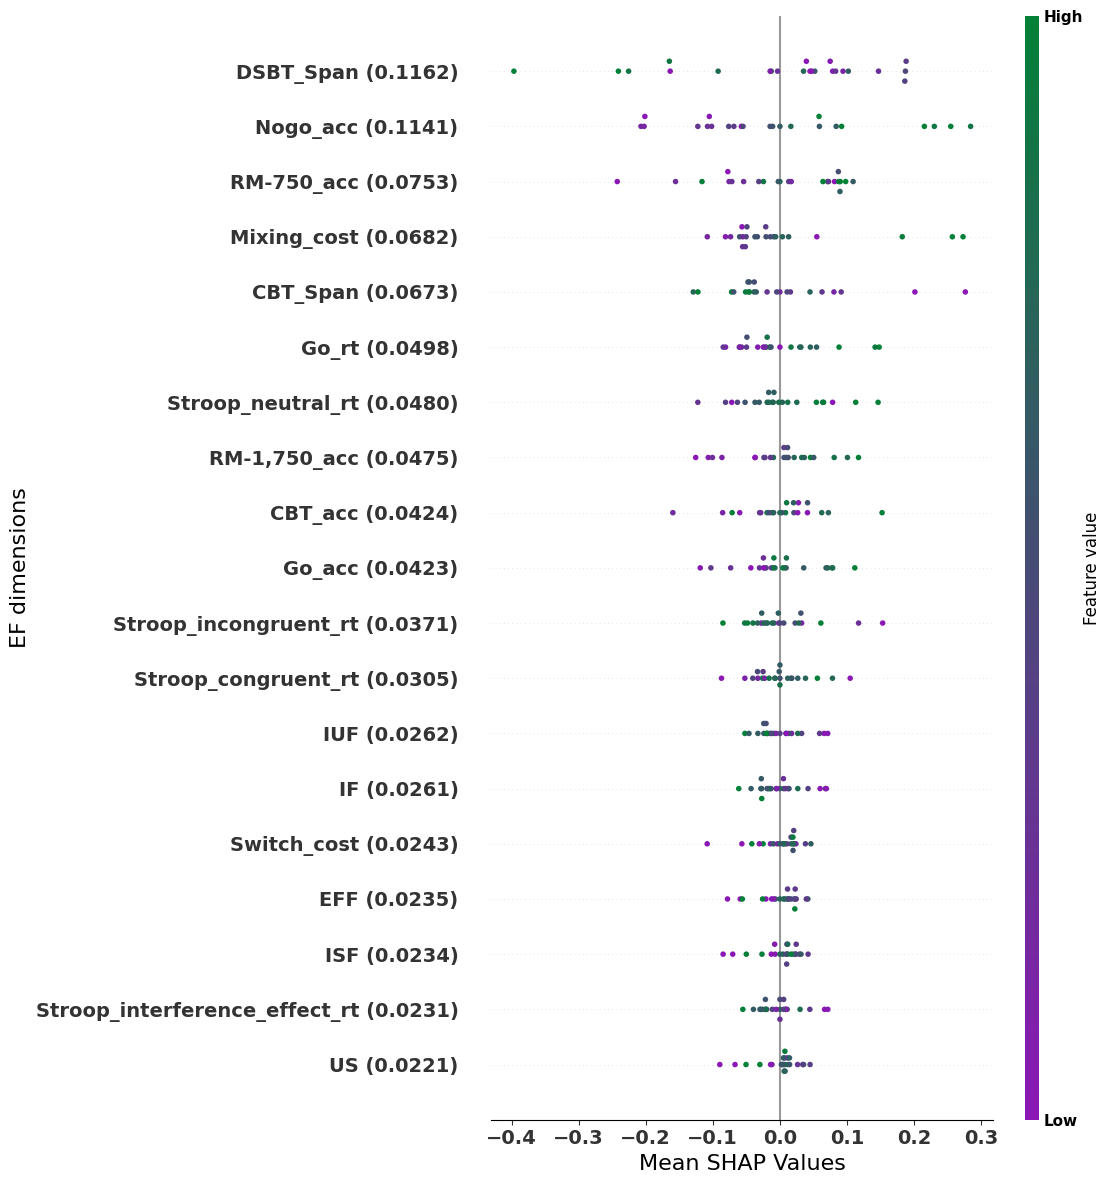

In [26]:
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import matplotlib as mpl
import numpy as np
import shap

# Function to convert hex color code to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    h_length = len(hex_color)
    return tuple(int(hex_color[i:i+h_length//3], 16)/255 for i in range(0, h_length, h_length//3))

# Define hex color codes
hex_color_negative = '#8b17b5'  # Dark purple for negative correlation
hex_color_positive = '#038037'  # Dark green for positive correlation

# Convert hex color codes to RGB color codes
rgb_color_negative = hex_to_rgb(hex_color_negative)
rgb_color_positive = hex_to_rgb(hex_color_positive)

# Combine RGB color codes
colors = [rgb_color_negative, rgb_color_positive]

# Create a color gradient
cmap = plt_colors.LinearSegmentedColormap.from_list("", colors)

# Generate SHAP value violin plot
shap.summary_plot(shap_values, X_test, plot_size=(10,12), show=False, max_display=35, cmap=cmap)

ax = plt.gca()

# 获取 y 轴标签
yticklabels = ax.get_yticklabels()

feature_ordering = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]

# 设置 y 轴标签，并添加 SHAP 值
ax.set_yticklabels([f'{X_test.columns[feature_ordering[len(yticklabels)-i-1]]} ({mean_abs_shap_values[feature_ordering[len(yticklabels)-i-1]]:.4f})' for i in range(len(yticklabels))])

# 设置 x 轴和 y 轴的字体大小和粗细
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 设置 x 轴和 y 轴的标题，并指定字体大小
ax.set_xlabel('Mean SHAP Values', fontsize=16)
ax.set_ylabel('EF dimensions', fontsize=16)

plt.savefig('image/summary_plot-散点图-自定义颜色.jpg', dpi=600, bbox_inches='tight')

plt.show()

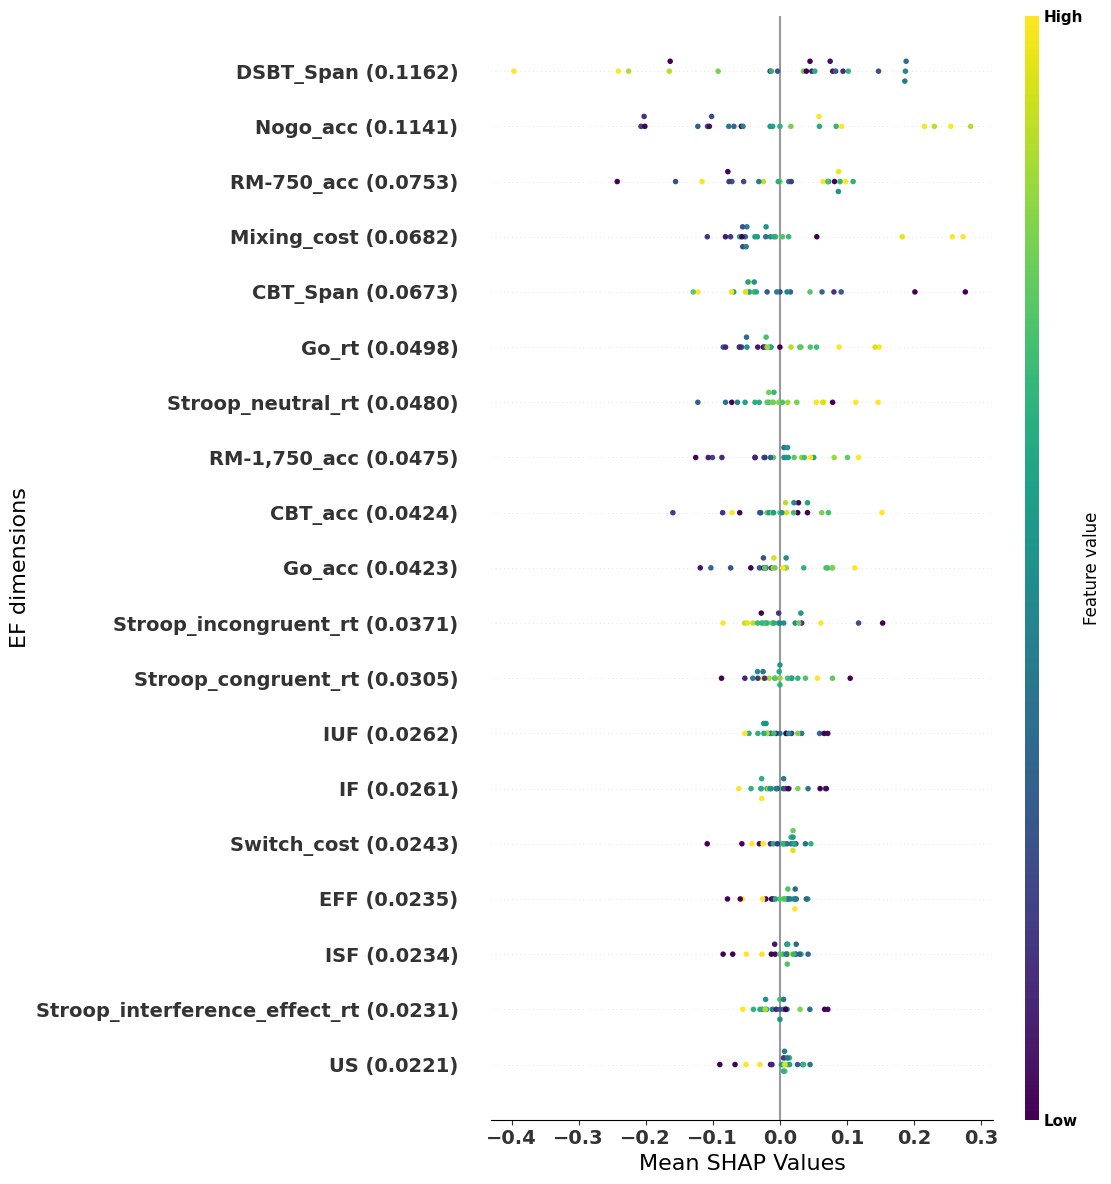

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shap

# 计算每个特征的 SHAP 值的绝对值的平均值
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# 设置全局的字体大小和粗细
mpl.rcParams['font.size'] = 14

# 生成 SHAP 值的小提琴图
shap.summary_plot(shap_values, X_test, plot_size=(10,12), show=False, max_display=35, cmap='viridis')


ax = plt.gca()

# 获取 y 轴标签
yticklabels = ax.get_yticklabels()

feature_ordering = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]

# 设置 y 轴标签，并添加 SHAP 值
ax.set_yticklabels([f'{X_test.columns[feature_ordering[len(yticklabels)-i-1]]} ({mean_abs_shap_values[feature_ordering[len(yticklabels)-i-1]]:.4f})' for i in range(len(yticklabels))])

# 设置 x 轴和 y 轴的字体大小和粗细
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 设置 x 轴和 y 轴的标题，并指定字体大小
ax.set_xlabel('Mean SHAP Values', fontsize=16)
ax.set_ylabel('EF dimensions', fontsize=16)

plt.savefig('image/summary_plot-散点图-绿黄配色.jpg', dpi=600, bbox_inches='tight')

plt.show()

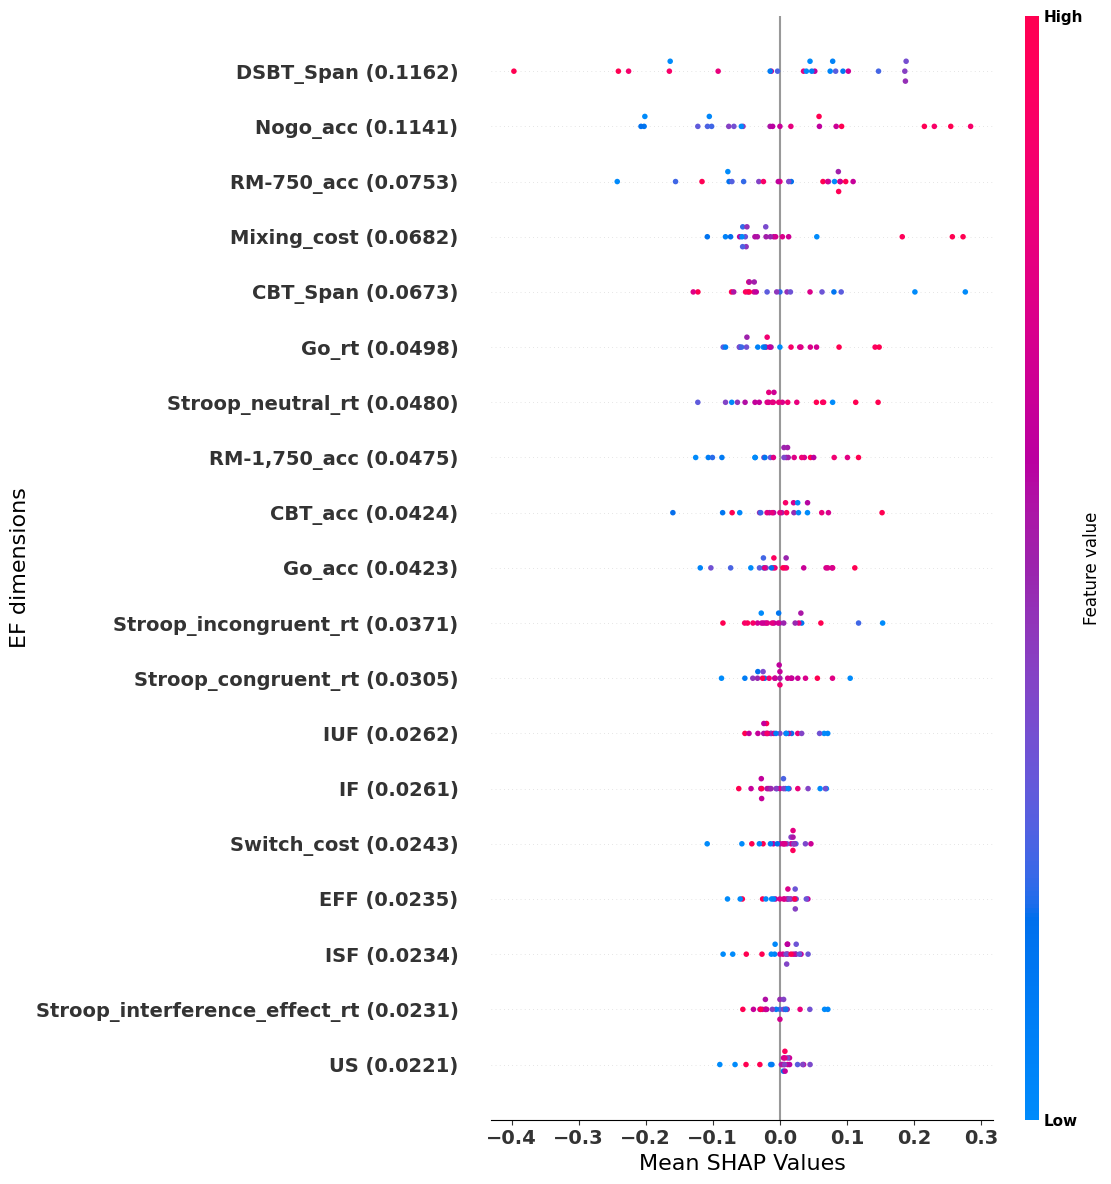

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import shap

# 计算每个特征的 SHAP 值的绝对值的平均值
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# 设置全局的字体大小和粗细
mpl.rcParams['font.size'] = 14

# 生成 SHAP 值的小提琴图
shap.summary_plot(shap_values, X_test, plot_size=(10,12), show=False, max_display=20)


ax = plt.gca()

# 获取 y 轴标签
yticklabels = ax.get_yticklabels()

feature_ordering = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]

# 设置 y 轴标签，并添加 SHAP 值
ax.set_yticklabels([f'{X_test.columns[feature_ordering[len(yticklabels)-i-1]]} ({mean_abs_shap_values[feature_ordering[len(yticklabels)-i-1]]:.4f})' for i in range(len(yticklabels))])

# 设置 x 轴和 y 轴的字体大小和粗细
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 设置 x 轴和 y 轴的标题，并指定字体大小
ax.set_xlabel('Mean SHAP Values', fontsize=16)
ax.set_ylabel('EF dimensions', fontsize=16)

plt.savefig('image/summary_plot-散点图-原始配色.jpg', dpi=600, bbox_inches='tight')

plt.show()

### 全部完成！

In [29]:
print("全部完成!")

全部完成!
